https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/

In [1]:
import warnings                           
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

from utils import mean_absolute_percentage_error, timeseries_train_test_split, train_test_split

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
data = pd.read_excel('./data/день - количество блюд.xlsx', skiprows= 3, usecols= [0,1], names = ['date', 'meals'])
print(data.shape)
data.head()

(898, 2)


,date,meals
0,2018-04-06 00:00:00,32.0
1,2018-04-07 00:00:00,8.0
2,2018-04-08 00:00:00,4.0
3,2018-04-09 00:00:00,14.0
4,2018-04-10 00:00:00,5.0


In [3]:
# remove the last row
data = data.iloc[:-1]

In [4]:
data['date'] = pd.to_datetime(data['date'])
after_covid_df = data[data['date'] > '2020-05-01 00:00:00']
#after_covid_df = data.loc[(data['date'] > '2020-05-15 00:00:00') | (data['date'] < '2020-03-01 00:00:00')] 
print(after_covid_df.shape)
after_covid_df.head()

(143, 2)


,date,meals
754,2020-05-02,86.0
755,2020-05-03,92.0
756,2020-05-04,89.0
757,2020-05-05,65.0
758,2020-05-06,101.0


In [5]:
after_covid_df = after_covid_df.set_index('date')

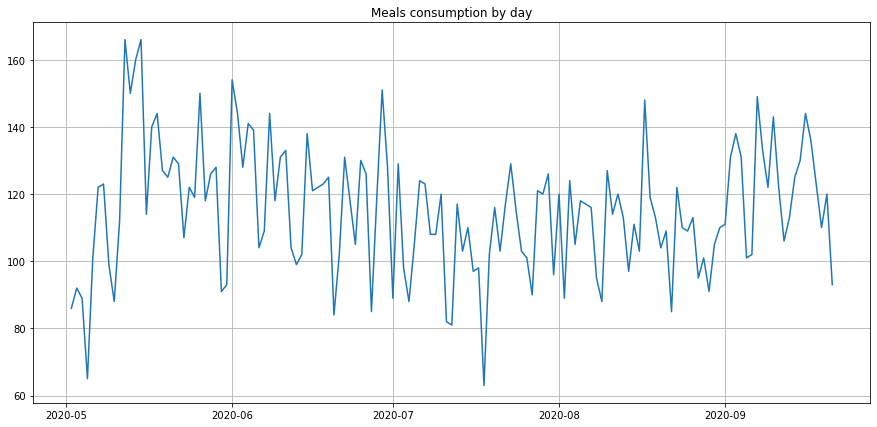

In [6]:
plt.figure(figsize=(15,7))
plt.plot(after_covid_df)
plt.title('Meals consumption by day')
plt.grid(True)
plt.show()

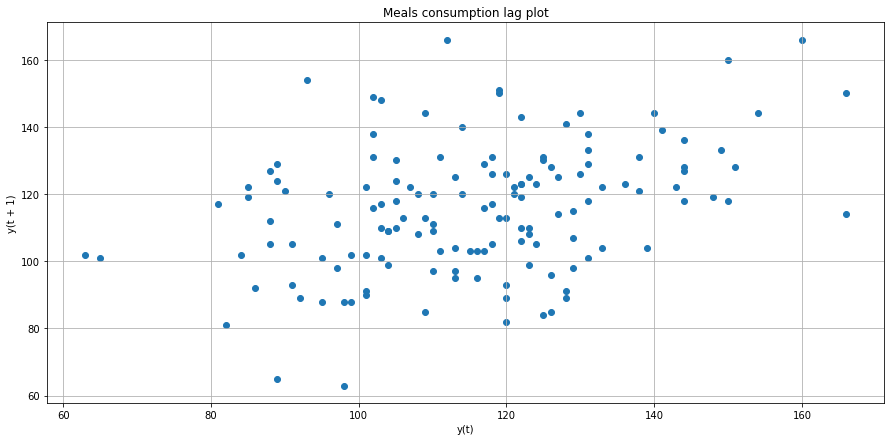

In [7]:
plt.figure(figsize=(15,7))
lag_plot(after_covid_df)
plt.title('Meals consumption lag plot')
plt.grid(True)
plt.show()

In [8]:
after_covid_df = pd.DataFrame(after_covid_df.meals.copy())
after_covid_df.columns = ["target"]

In [9]:
# Adding the lag of the target varable from 7 steps back (week) up to 30 (month)

for i in range(1, 21):
    after_covid_df["lag_{}".format(i)] = after_covid_df.target.shift(i)

In [10]:
after_covid_df.shape

(143, 21)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(after_covid_df)

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    return lr

In [ ]:
lr = linear_regression_model(X_train, y_train)

In [ ]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [ ]:
plotModelResults(lr, X_train, X_test, plot_intervals=True)
plotCoefficients(lr)

### Regularization and feature selection

In [ ]:
sns.heatmap(X_train.corr());

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

In [ ]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)